In [1]:
import casadi as ca
from casadi.tools.graph import graph
import matplotlib.image as mpimg
from io import BytesIO
import matplotlib.pyplot as plt
import os
from IPython.display import Image


def draw_graph(x):
    g = graph.dotgraph(x)
    #g.set('dpi', 300)
    png = g.create('dot', 'png')
    return Image(png)

We first derive the filter and symbolically run it for 6 cycles to see the covariance matrix propagation pattern.

In [2]:
n_x = 6
n_u = 3
n_y = 6
x = ca.SX.sym('x', n_x)
t = ca.SX.sym('t')
x0 = ca.SX.sym('x0', n_x)
u = ca.SX.sym('u', n_u)
f = ca.Function('f', [x, u], [ca.vertcat(x[3:6], u[0:3])])
g = ca.Function('g', [x, u], [x[0:6]])

F = ca.Function('F', [x, u], [ca.jacobian(f(x, u), x)])
H = ca.Function('H', [x, u], [ca.jacobian(g(x, u), x)])

P0 = ca.SX.sym('P0', ca.Sparsity.diag(n_x))
Q = ca.SX.sym('Q', ca.Sparsity.diag(n_x))
R = ca.SX.sym('R', ca.Sparsity.diag(n_y))
dt = ca.SX.sym('dt')
v = ca.SX.sym('v', n_y)

xi = x0
Pi = P0

# propagate by dimension of state to ensure propagation is complete
# and Pi has all required entries
for i in range(n_x):
    # predict
    dx = f(x, u)
    xi += dx*dt
    Fi = F(x, u)
    dP = ca.mtimes(Fi, Pi) + ca.mtimes(Pi, Fi.T) + Q
    Pi += dP*dt
    
    # correct
    yi = g(xi, u) + v
    r = yi - g(xi, u)
    Hi = H(x, u)
    Si = ca.mtimes([Hi, Pi, Hi.T]) + R
    Si_inv = ca.inv(Si)
    beta = ca.mtimes([r.T, Si_inv, r])
    Ki = ca.mtimes([Pi, Hi.T, Si_inv])
    dP = -ca.mtimes([Ki, Hi, Pi])
    Pi += dP
    dx = ca.mtimes(Ki, r)
    xi += dx

Pi.sparsity().spy()

*..*..
.*..*.
..*..*
*..*..
.*..*.
..*..*


Now that we have the pattern of the covariance matrix, we can exploit it to make the filter more efficient. Because we are using sparse matrix invesion, it is imporant to compute the condition number, so that we can ensure the inversion will be numerically well conditioned.

In [3]:
# sparsify equations using P sparsity pattern
PU = ca.SX.sym('P', ca.triu(Pi).sparsity())
P = ca.triu2symm(PU)
y = ca.SX.sym('y', n_y)
r = y - g(x, u)
Hi = H(x, u)
Si = ca.mtimes([Hi, P, Hi.T]) + R
Si_inv = ca.inv(Si)
beta = ca.mtimes([r.T, Si_inv, r])
Ki = ca.mtimes([P, Hi.T, Si_inv])
dPU = -ca.triu(ca.mtimes([Ki, Hi, P]))
dx = ca.mtimes(Ki, r)

# find condition number
def condition_number(P):
    eig = ca.fabs(ca.eig_symbolic(P))
    min_eig = ca.mmin(eig)
    return ca.if_else(min_eig < 1e-5, ca.inf, ca.mmax(eig)/ca.mmin(eig))

x_dot = ca.Function('x_dot', [x, u], [f(x, u)], ['x', 'u'], ['x_dot'])
P_dot = ca.Function('P_dot', [x, u, PU, Q], [ca.mtimes(F(x, u), P) + ca.mtimes(P, F(x, u).T) + Q],
                   ['x', 'u', 'PU', 'Q'], ['P_dot'])

f_cond = ca.Function('cond', [x, u, PU, R], [condition_number(Si),],
                       ['x', 'u', 'PU', 'R'], ['cond'])
f_correct = ca.Function('correct', [x, u, y, PU, R], [dx, dPU, beta],
                       ['x', 'u', 'y', 'PU', 'R'], ['dx', 'dPU', 'beta'])
print(f_cond)
print(f_correct)

cond:(x[6],u[3],PU[6x6,9nz],R[6x6,6nz])->(cond) SXFunction
correct:(x[6],u[3],y[6],PU[6x6,9nz],R[6x6,6nz])->(dx[6],dPU[6x6,9nz],beta) SXFunction


It is possible to use a Runge-Kutta 4th order integrator if necessary.

In [4]:
def rk4(f, t, y, h):
    """Runge Kuta 4th order integrator"""
    k1 = h*f(t, y)
    k2 = h*f(t + h/2, y + k1/2)
    k3 = h*f(t + h/2, y + k2/2)
    k4 = h*f(t + h, y + k3)
    return ca.simplify(y + (k1 + 2*k2 + 2*k3 + k4)/6)
          
#draw_graph(x_predict_rk4)

In [5]:
#draw_graph(predict_rk4(t, dt, x, u, PU, Q)[1])

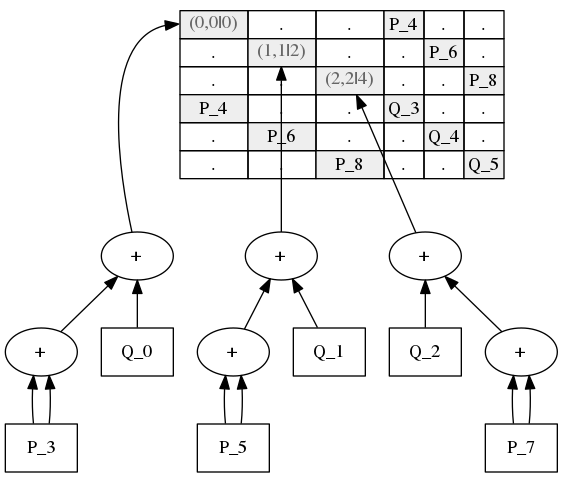

In [6]:
draw_graph(P_dot(x, u, P, Q))

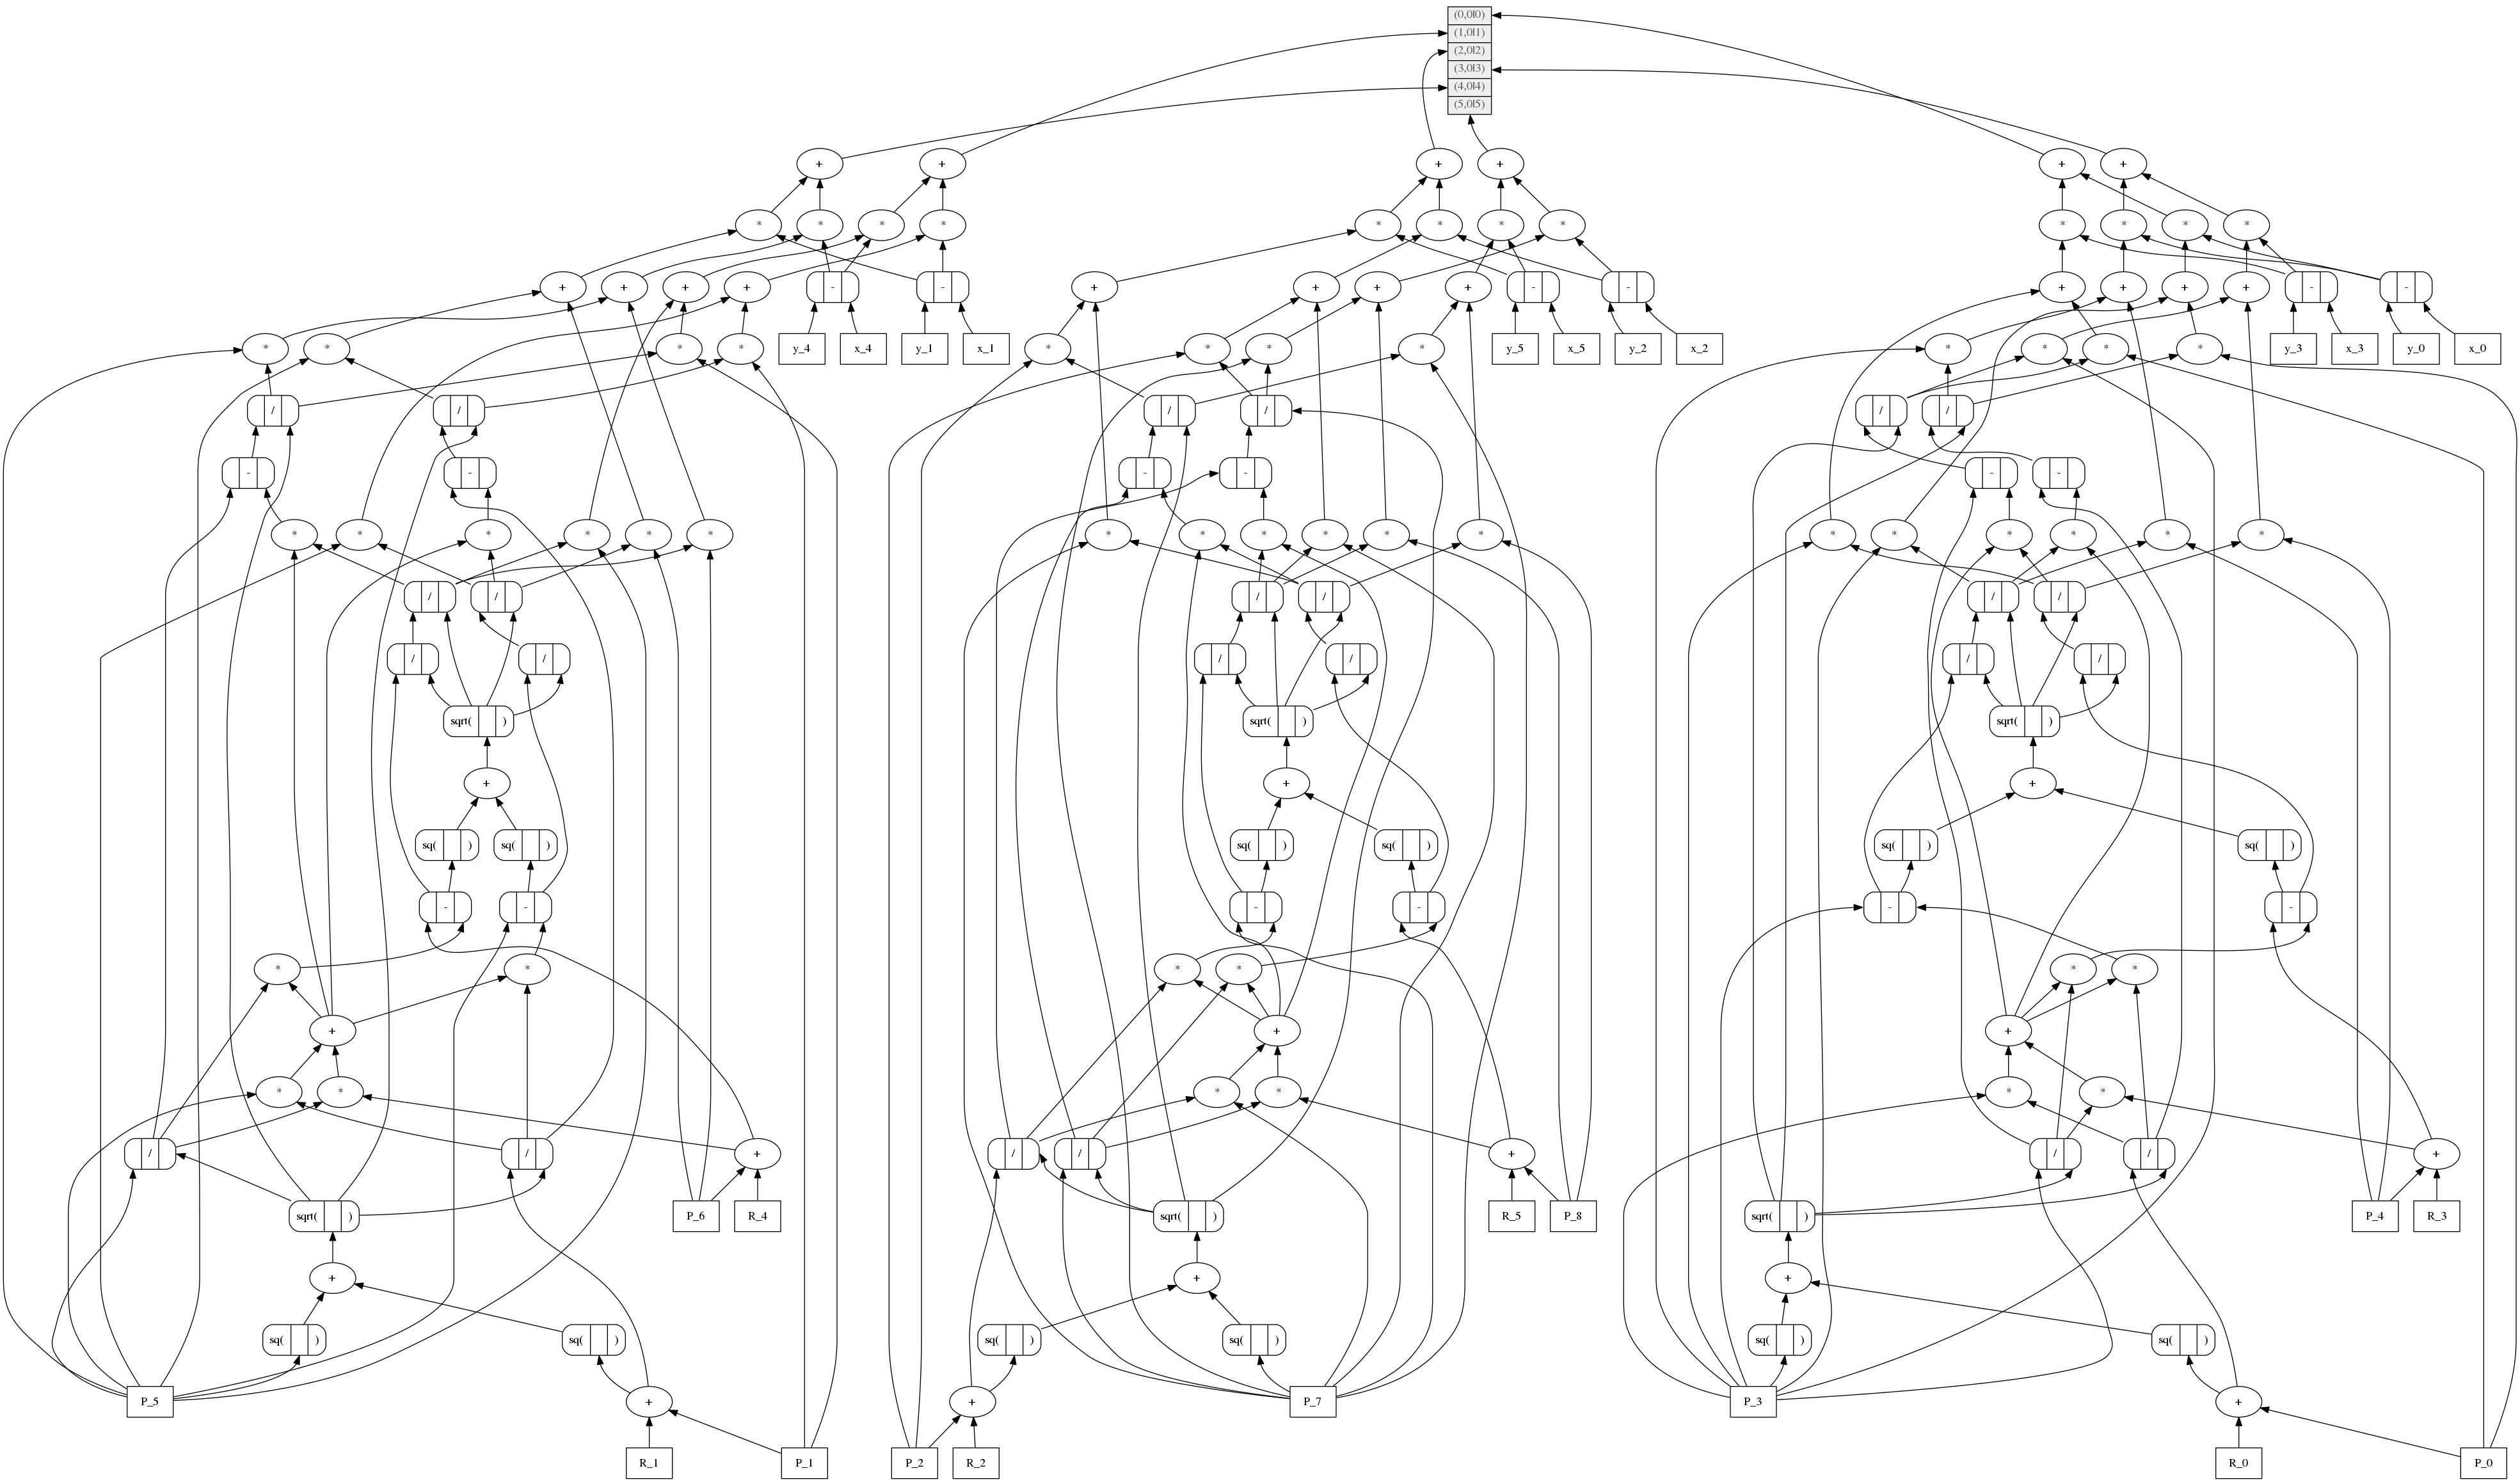

In [7]:
draw_graph(f_correct(x, u, y, P, R)[0])

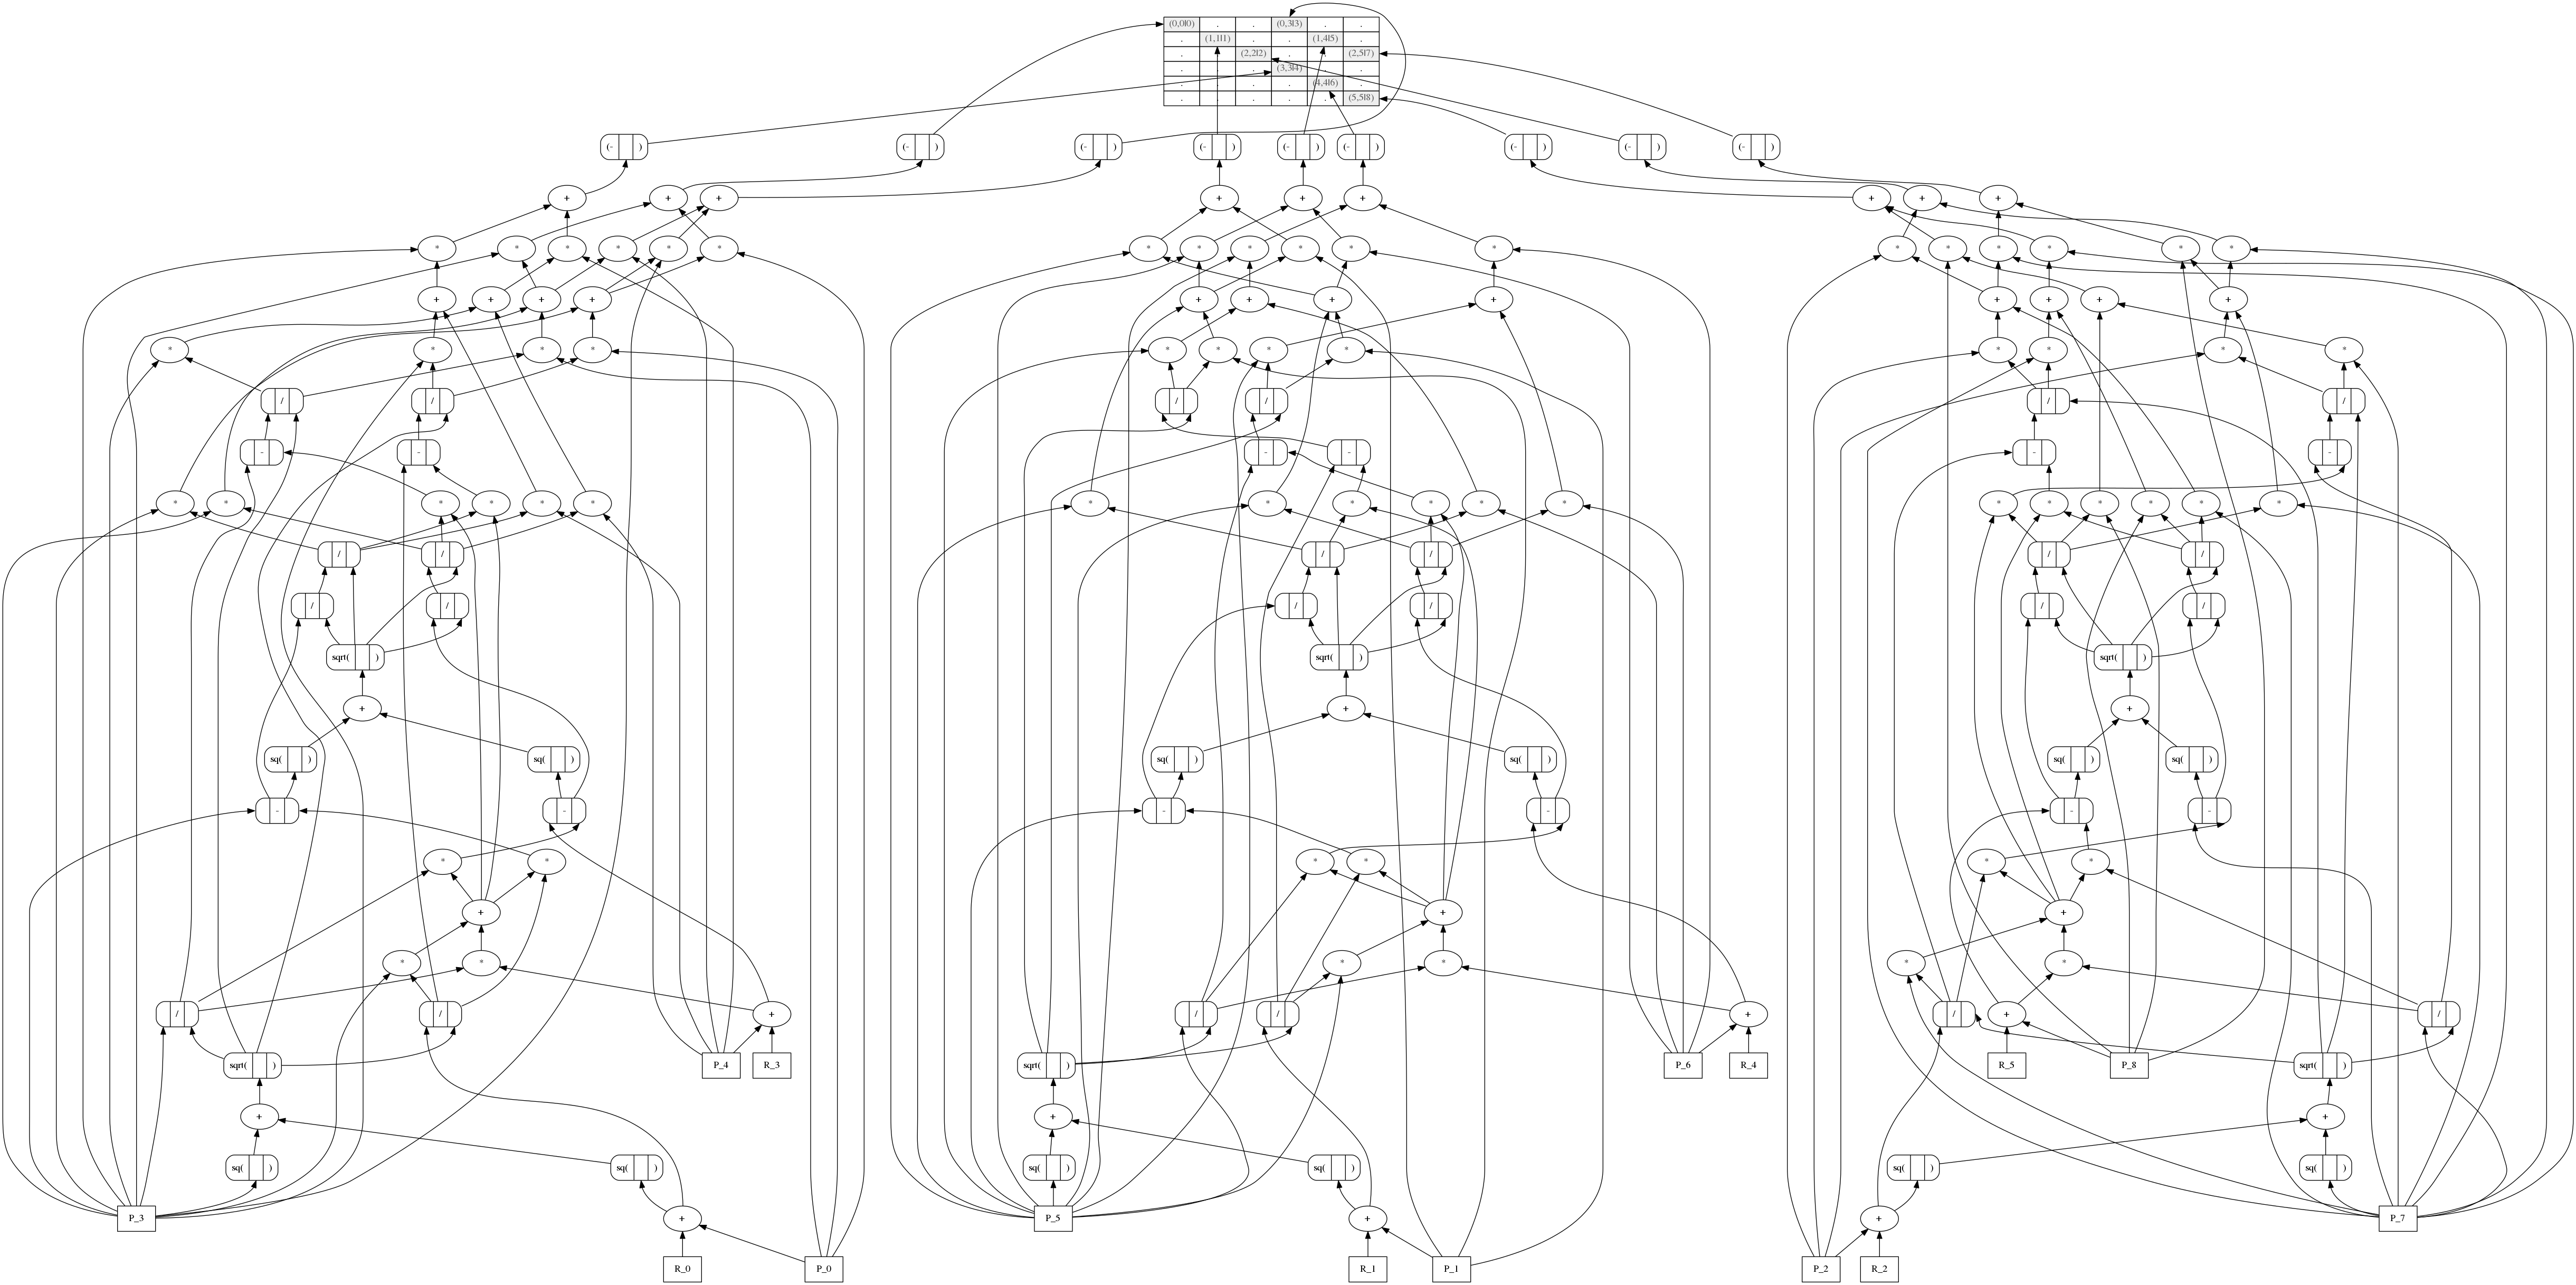

In [8]:
draw_graph(f_correct(x, u, y, P, R)[1])

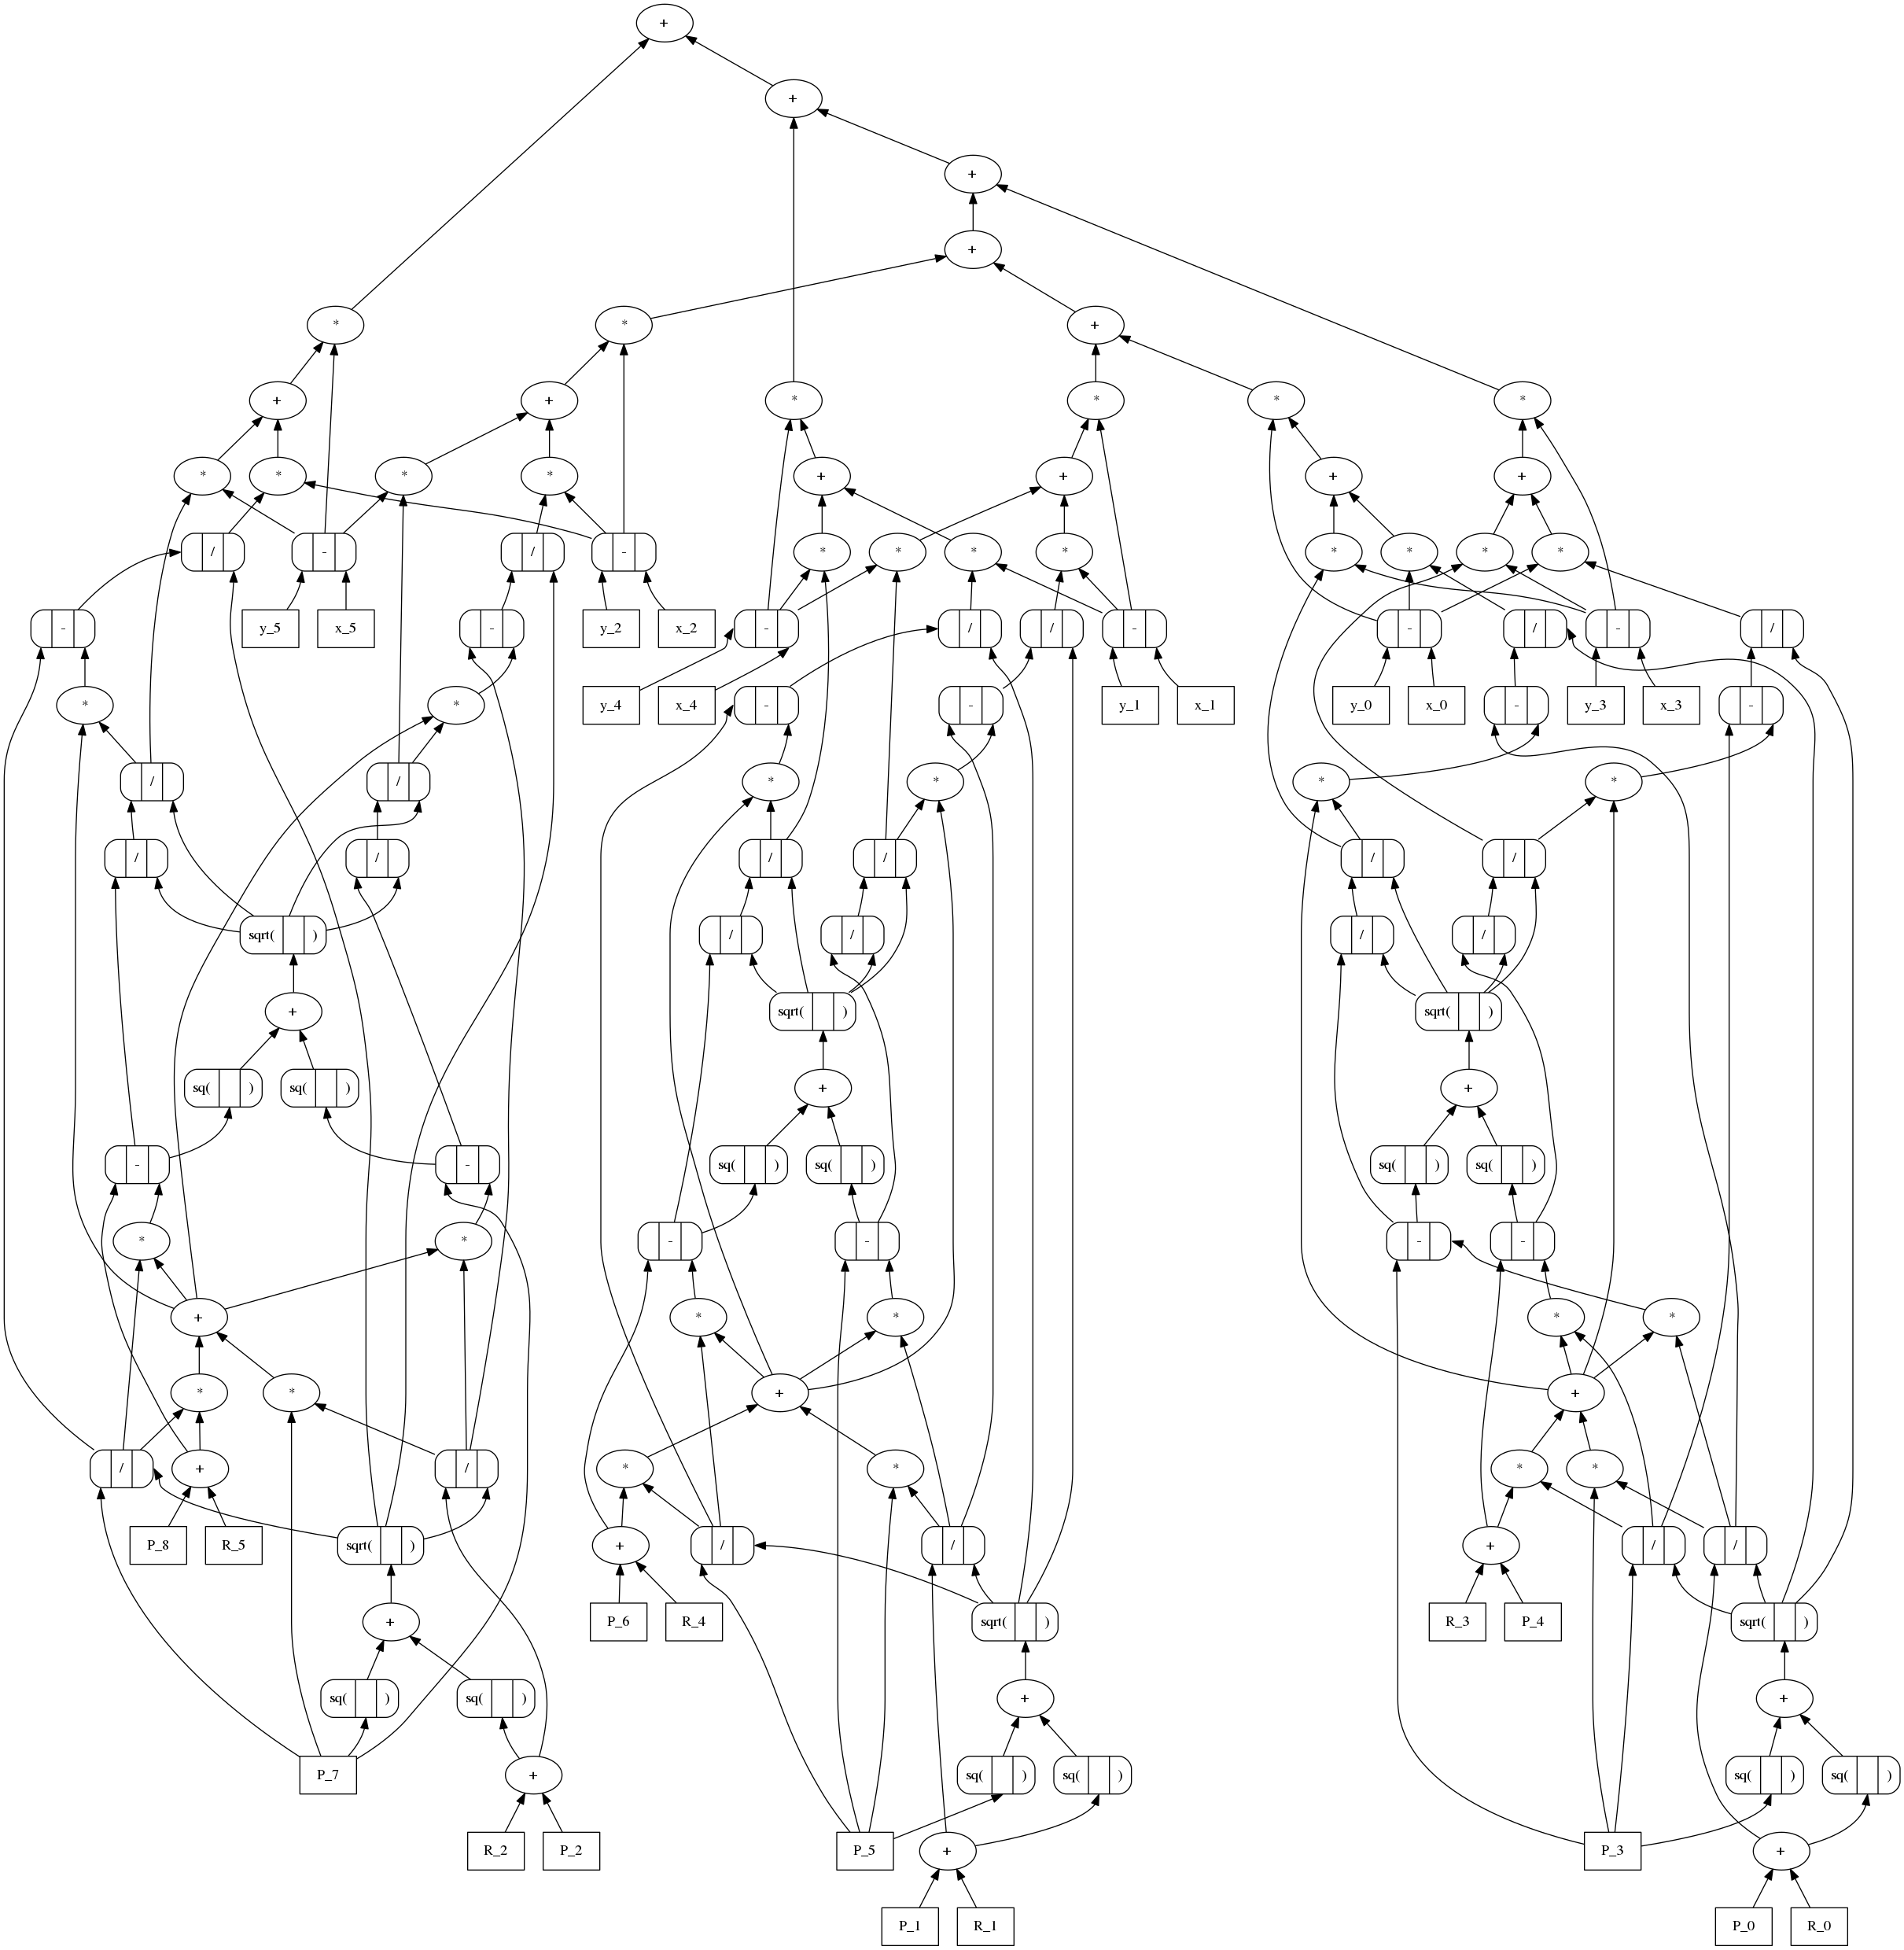

In [9]:
draw_graph(f_correct(x, u, y, P, R)[2])

In [10]:
PU

SX(
[[P_0, 00, 00, P_3, 00, 00], 
 [00, P_1, 00, 00, P_5, 00], 
 [00, 00, P_2, 00, 00, P_7], 
 [00, 00, 00, P_4, 00, 00], 
 [00, 00, 00, 00, P_6, 00], 
 [00, 00, 00, 00, 00, P_8]])

In [11]:
def create_P_init(PU):
    P0 = ca.SX(PU)
    for s in PU.nonzeros():
        P0 = ca.substitute(P0, s, 1)
    return ca.Function('P_init', [], [P0], [], ['P0'])
P_init = create_P_init(PU)

In [12]:
# code generation
gen = ca.CodeGenerator('casadi_sekf.c', {'main': False, 'mex': False, 'with_header': True, 'with_mem': True})
gen.add(x_dot)
gen.add(P_dot)
gen.add(f_correct)
gen.add(f_cond)
gen.add(P_init)
gen.generate('/home/jgoppert/git/phd/px4/src/modules/cei/ekf/')

'/home/jgoppert/git/phd/px4/src/modules/cei/ekf/casadi_sekf.c'